### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 5
### Due: Friday, Mar 7nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

Part 1

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from dynesty import NestedSampler

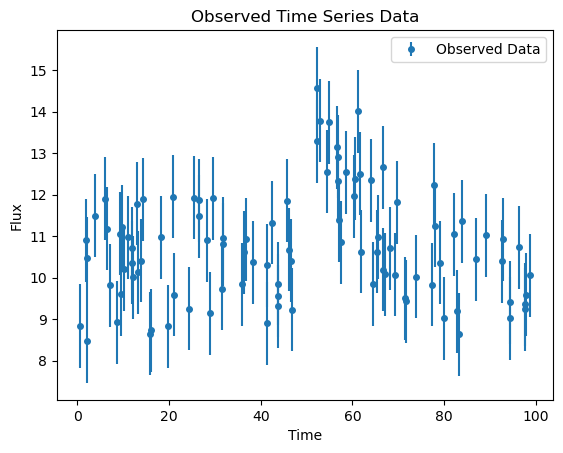

In [2]:
data = np.load('hw_data/hw5_data_1.npy')

t = data[:, 0]
y = data[:, 1] 
sigma = data[:, 2] 

# Plot the data
plt.errorbar(t, y, yerr=sigma, fmt='o', markersize=4, label='Observed Data')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Observed Time Series Data')
plt.legend()
plt.show()

Part 2

In [3]:
def burst_model(t, b, A, t0, alpha):
    y_model = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
    return y_model

def log_likelihood(params, t, y, sigma):
    b, A, t0, log_alpha = params
    alpha = np.exp(log_alpha)  # Transform log_alpha to alpha
    y_model = burst_model(t, b, A, t0, alpha)
    logL = -0.5 * np.sum(((y - y_model) / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))
    return logL


Part 3

In [48]:
# Define prior transform function
def log_prior(params):
    b, A, t0, log_alpha = params
    if 0 <= b <= 50 and 0 <= A <= 50 and 0 <= t0 <= 100 and -5 <= log_alpha <= 5:
        return 0.0  # log(1) since uniform prior
    return -np.inf  # log(0)

# Define posterior probability
def log_posterior(params, t, y, sigma):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, t, y, sigma)

# MCMC setup
ndim = 4
nwalkers = 10
nsteps = 10000
p0 = np.random.uniform([0, 0, 0, -5], [50, 50, 100, 5], size=(nwalkers, ndim))

# Part 4
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t, y, sigma))
sampler.run_mcmc(p0, nsteps, progress=True)

# Extract chain
samples = sampler.get_chain(discard=1000, thin=10, flat=True)


C:\Users\Rahul E\AppData\Local\Temp\ipykernel_181260\589710570.py:2: RuntimeWarning: overflow encountered in exp
  y_model = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Rahul E\AppData\Local\Temp\ipykernel_181260\589710570.py:2: RuntimeWarning: overflow encountered in multiplys]
  y_model = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2345.07it/s]


<span style="color:red"> NP: missing part 4 chain diagnostics (and you can see the effect in the corner plot below). -3 pts </span>

Part 5

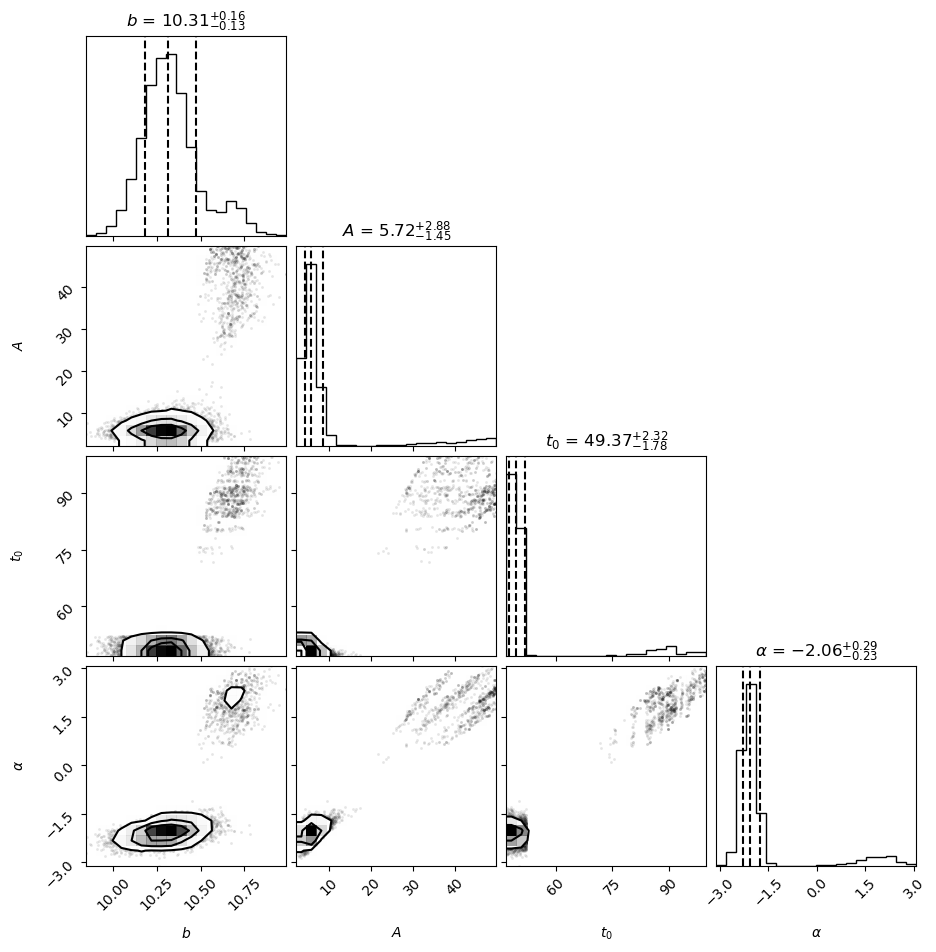

In [50]:
labels = [r'$b$', r'$A$', r'$t_0$', r'$\alpha$']
fig = corner.corner(samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True)
plt.show()


Part 6

C:\Users\Rahul E\AppData\Local\Temp\ipykernel_181260\589710570.py:2: RuntimeWarning: overflow encountered in exp
  y_model = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Rahul E\AppData\Local\Temp\ipykernel_181260\589710570.py:2: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))


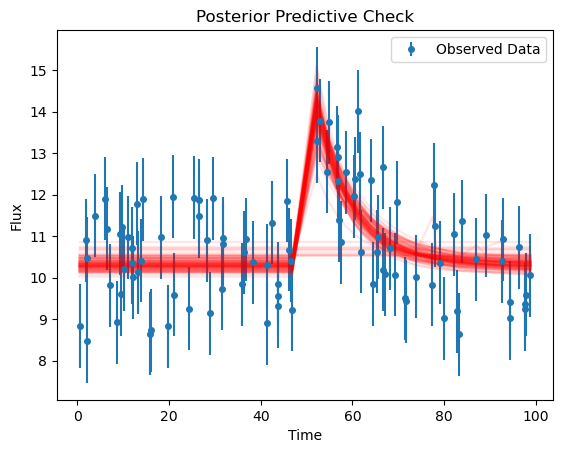

In [72]:
plt.errorbar(t, y, yerr=sigma, fmt='o', markersize=4, label='Observed Data')

for s in samples[np.random.choice(len(samples), 100)]:
    plt.plot(t, burst_model(t, s[0] , s[1] , s[2] , np.exp(s[3])), alpha=0.1, color='red')

plt.xlabel('Time')
#plt.xlim(0,90)
#plt.ylim(7,15)
plt.ylabel('Flux')
plt.title('Posterior Predictive Check')
plt.legend()
plt.show()

Part 7

In [74]:
def gaussian_model(t, b, A, t0, sigma_w):
    return b + A * np.exp(-((t - t0) ** 2) / (2 * sigma_w ** 2))

def log_likelihood_gaussian(params, t, y, sigma):
    b, A, t0, log_sigma_w = params
    sigma_w = np.exp(log_sigma_w)
    y_model = gaussian_model(t, b, A, t0, sigma_w)
    return -0.5 * np.sum(((y - y_model) / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))


def prior_transform(unit_params):
    b = unit_params[0] * 50  # Scale [0,1] to [0,50]
    A = unit_params[1] * 50
    t0 = unit_params[2] * 100
    log_sigma_w = unit_params[3] * 7 - 2  # Scale to [-2,2]
    return b, A, t0, log_sigma_w

# Run nested sampling
sampler = NestedSampler(log_likelihood_gaussian, prior_transform, ndim=4, logl_args=(t, y, sigma))
sampler.run_nested()
results = sampler.results
logZ_gaussian = results.logz[-1]


D:\Softwares\miniconda\envs\new_env\lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
D:\Softwares\miniconda\envs\new_env\lib\site-packages\dynesty\bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
D:\Softwares\miniconda\envs\new_env\lib\site-p

In [77]:
def prior_transform_g(u):
    b = 50 * u[0]  # Uniform[0,50]
    A = 50 * u[1]  # Uniform[0,50]
    t0 = 100 * u[2]  # Uniform[0,100]
    log_alpha = -5 + 10 * u[3]  # Uniform[-5,5]
    return [b, A, t0, log_alpha]

sampler_g = NestedSampler(log_likelihood, prior_transform_g, ndim=4, logl_args=(t, y, sigma))
sampler_g.run_nested()

# Get results
results_burst = sampler_g.results
logZ_burst = results_burst.logz[-1]

C:\Users\Rahul E\AppData\Local\Temp\ipykernel_181260\589710570.py:2: RuntimeWarning: overflow encountered in exp
  y_model = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Rahul E\AppData\Local\Temp\ipykernel_181260\589710570.py:2: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Rahul E\AppData\Local\Temp\ipykernel_181260\589710570.py:2: RuntimeWarning: overflow encountered in exp inf | logz: -373.588 +/-  0.124 | dlogz: 203.069 >  0.509]   
  y_model = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Rahul E\AppData\Local\Temp\ipykernel_181260\589710570.py:2: RuntimeWarning: overflow encountered in multiply
  y_model = np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))
C:\Users\Rahul E\AppData\Local\Temp\ipykernel_181260\589710570.py:2: RuntimeWarning: overflow encountered in expinf | logz: -264.462 +/-  0.123 | dlogz: 97.532 >  0.509]  
  y_model = np.where(t < t0, b, b + 

In [78]:
bayes_factor = np.exp(logZ_burst - logZ_gaussian)
print(f"Bayes Factor: {bayes_factor}")

if bayes_factor > 1:
    print("Burst model is preferred.")
else:
    print("Gaussian model is preferred.")

Bayes Factor: 175.00498422813158
Burst model is preferred.
